# Intro

Welcome to the [BirdCLEF 2021 - Birdcall Identification](https://www.kaggle.com/c/birdclef-2021/overview) compedition.

![](https://storage.googleapis.com/kaggle-competitions/kaggle/25954/logos/header.png)

We will give you first a short introduction to start with your work. The nex step is to show a short analysis befor definen a model with keras.

We recommend [this notebook](https://www.kaggle.com/drcapa/recognizesongapp-fromscratch-tutorial) for handling audio data tutorial.

<span style="color: royalblue;">Please vote the notebook up if it helps you. Feel free to leave a comment above the notebook. Thank you. </span>

# Libraries

In [2]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import soundfile as sf
import librosa
import librosa.display
import IPython.display as display

from sklearn.model_selection import train_test_split

from tensorflow.keras.utils import Sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv1D, MaxPool1D, BatchNormalization
from tensorflow.keras.optimizers import RMSprop,Adam
from tensorflow.keras.applications import VGG19, VGG16, ResNet50

import warnings
warnings.filterwarnings("ignore")

/home/phunc20/.config/miniconda3/envs/py3.6/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/phunc20/.config/miniconda3/envs/py3.6/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/phunc20/.config/miniconda3/envs/py3.6/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/phunc20/.conf

<s>Dunno why but `librosa`'s installation seems to be troublesome on my X200 (miniconda)</s>  
Worked fine after restart the notebook.

# Path

In [3]:
#path = '/kaggle/input/birdclef-2021/'
path = "/home/phunc20/datasets/kaggle/birdclef-2021/"
os.listdir(path)

['test_soundscapes',
 'test.csv',
 'train_soundscapes',
 'train_soundscape_labels.csv',
 'train_short_audio',
 'train_metadata.csv',
 'sample_submission.csv']

# Functions
We define some helper functions.

In [4]:
def read_ogg_file(path, file):
    """ Read ogg audio file and return numpay array and samplerate"""
    
    data, samplerate = sf.read(path+file)
    return data, samplerate


def plot_audio_file(data, samplerate):
    """ Plot the audio data"""
    
    sr = samplerate
    fig = plt.figure(figsize=(8, 4))
    x = range(len(data))
    y = data
    plt.plot(x, y)
    plt.plot(x, y, color='red')
    plt.legend(loc='upper center')
    plt.grid()
    
    
def plot_spectrogram(data, samplerate):
    """ Plot spectrogram with mel scaling """
    
    sr = samplerate
    spectrogram = librosa.feature.melspectrogram(data, sr=sr)
    log_spectrogram = librosa.power_to_db(spectrogram, ref=np.max)
    librosa.display.specshow(log_spectrogram, sr=sr, x_axis='time', y_axis='mel')

# Load Data

In [5]:
train_labels = pd.read_csv(path+'train_soundscape_labels.csv')
train_meta = pd.read_csv(path+'train_metadata.csv')
test_data = pd.read_csv(path+'test.csv')
samp_subm = pd.read_csv(path+'sample_submission.csv')

# Overview

In [6]:
print('Number train label samples:', len(train_labels))
print('Number train meta samples:', len(train_meta))
print('Number train short folder:', len(os.listdir(path+'train_short_audio')))
print('Number train audios:', len(os.listdir(path+'train_soundscapes')))
print('Number test samples:', len(test_data))

Number train label samples: 2400
Number train meta samples: 62874
Number train short folder: 397
Number train audios: 20
Number test samples: 3


### Let's Check
- `len(train_labels)`: Why `2400`?
- `len(train_meta)`: why `62874`?
- `len(os.listdir(path+'train_short_audio')))` represents `# distinct birds`

**`len(train_labels)`**  
`train_soundscape_labels.csv` contains, for each of the **20** `.ogg` files in `train_soundscapes/` labels
ending with `_5`, `_10`, ..., `600`, reflecting the fact that each audio file is about 10 minutes,
i.e. **600** seconds. At this point, we can check whether `len(train_labels)` is reasonable:

In [7]:
!ls $path/train_soundscapes | wc -l

20


In [8]:
n_audios = 20
n_labels_per_video = 120
n_audios * n_labels_per_video == len(train_labels)

True

Let's try to use `pathlib` instead of `os` with strings.

In [9]:
from pathlib import Path

In [10]:
path_birdclef2021 = Path(path)
path_birdclef2021

PosixPath('/home/phunc20/datasets/kaggle/birdclef-2021')

In [11]:
for f in path_birdclef2021.iterdir():
    print(f.name)

test_soundscapes
test.csv
train_soundscapes
train_soundscape_labels.csv
train_short_audio
train_metadata.csv
sample_submission.csv


In `train_meta` there is a column named `"filename"` whose values look like the audio filenames in `train_short_audio/`.

In [12]:
train_meta["filename"].head()

0    XC109605.ogg
1     XC11209.ogg
2    XC127032.ogg
3    XC129974.ogg
4    XC129981.ogg
Name: filename, dtype: object

In [13]:
!find $path_birdclef2021 -name "XC109605.ogg"

/home/phunc20/datasets/kaggle/birdclef-2021/train_short_audio/acafly/XC109605.ogg


A quick way to verify `len(train_meta)`:

In [14]:
len(train_meta)

62874

In [15]:
!find $path/train_short_audio -iname "*.ogg" | wc -l

62874


In [16]:
os.listdir(path+'train_short_audio/caltow')[:2]

['XC126360.ogg', 'XC125802.ogg']

In [17]:
train_labels.head()

,row_id,site,audio_id,seconds,birds
0,7019_COR_5,COR,7019,5,nocall
1,7019_COR_10,COR,7019,10,nocall
2,7019_COR_15,COR,7019,15,nocall
3,7019_COR_20,COR,7019,20,nocall
4,7019_COR_25,COR,7019,25,nocall


In [18]:
train_meta.head()

,primary_label,secondary_labels,type,latitude,longitude,scientific_name,common_name,author,date,filename,license,rating,time,url
0,acafly,['amegfi'],"['begging call', 'call', 'juvenile']",35.3860,-84.1250,Empidonax virescens,Acadian Flycatcher,Mike Nelson,2012-08-12,XC109605.ogg,Creative Commons Attribution-NonCommercial-Sha...,2.5,09:30,https://www.xeno-canto.org/109605
1,acafly,[],['call'],9.1334,-79.6501,Empidonax virescens,Acadian Flycatcher,Allen T. Chartier,2000-12-26,XC11209.ogg,Creative Commons Attribution-NonCommercial-Sha...,3.0,?,https://www.xeno-canto.org/11209
2,acafly,[],['call'],5.7813,-75.7452,Empidonax virescens,Acadian Flycatcher,Sergio Chaparro-Herrera,2012-01-10,XC127032.ogg,Creative Commons Attribution-NonCommercial-Sha...,3.0,15:20,https://www.xeno-canto.org/127032
3,acafly,['whwbec1'],['call'],4.6717,-75.6283,Empidonax virescens,Acadian Flycatcher,Oscar Humberto Marin-Gomez,2009-06-19,XC129974.ogg,Creative Commons Attribution-NonCommercial-Sha...,3.5,07:50,https://www.xeno-canto.org/129974
4,acafly,['whwbec1'],['call'],4.6717,-75.6283,Empidonax virescens,Acadian Flycatcher,Oscar Humberto Marin-Gomez,2009-06-19,XC129981.ogg,Creative Commons Attribution-NonCommercial-Sha...,3.5,07:50,https://www.xeno-canto.org/129981


Columns that might be useful:
- `latitude/longitude`
- `date`

# A Sample File
We focus on the sample in the first row of the train meta data.

In [19]:
row = 0
train_meta.iloc[row]

primary_label                                                  acafly
secondary_labels                                           ['amegfi']
type                             ['begging call', 'call', 'juvenile']
latitude                                                       35.386
longitude                                                     -84.125
scientific_name                                   Empidonax virescens
common_name                                        Acadian Flycatcher
author                                                    Mike Nelson
date                                                       2012-08-12
filename                                                 XC109605.ogg
license             Creative Commons Attribution-NonCommercial-Sha...
rating                                                            2.5
time                                                            09:30
url                                 https://www.xeno-canto.org/109605
Name: 0, dtype: obje

We extract to features, the primary label which is the name of the folder where the audio file is stored and the filename:

In [20]:
label = train_meta.loc[row, 'primary_label']
filename = train_meta.loc[row, 'filename']

# Check if the file is in the folder
filename in os.listdir(path+'train_short_audio/'+label)

True

Load the data and samplerate:

In [21]:
data, samplerate = sf.read(path+'train_short_audio/'+label+'/'+filename)
print(data[:8])
print(samplerate)

[ 6.04931074e-06  1.34679942e-06 -8.47729734e-06  1.84468427e-05
 -1.12858988e-05 -1.93318715e-06 -6.18334798e-06 -5.09791244e-05]
32000


No handles with labels found to put in legend.


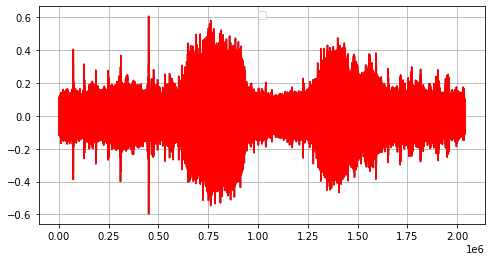

In [22]:
plot_audio_file(data, samplerate)

Plot [spectrogram](https://en.wikipedia.org/wiki/Spectrogram) with mel scaling:

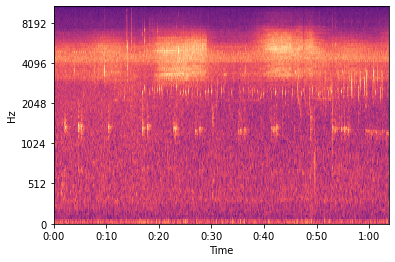

In [23]:
plot_spectrogram(data, samplerate)

Display the audio of the file:

In [24]:
display.Audio(path+'train_short_audio/'+label+'/'+filename)

**(?)** Dunno why the above display cannot play.

In [25]:
filename

'XC109605.ogg'

In [26]:
label

'acafly'

In [27]:
os.path.exists(path+'train_short_audio/'+label+'/'+filename)

True

# Exploratory Data Analysis
Our challenge is to identify which birds are calling in **long** recordings.

There are 20 long audio files in the folder train_soundscapes. And there are also 20 unique audio ids: 

In [28]:
train_labels.head()

,row_id,site,audio_id,seconds,birds
0,7019_COR_5,COR,7019,5,nocall
1,7019_COR_10,COR,7019,10,nocall
2,7019_COR_15,COR,7019,15,nocall
3,7019_COR_20,COR,7019,20,nocall
4,7019_COR_25,COR,7019,25,nocall


In [29]:
train_labels['audio_id'].unique()

array([ 7019,  7954, 11254, 18003, 21767, 26746, 31928, 44957, 50878,
       57610,  2782,  7843, 10534, 14473, 20152, 26709, 28933, 42907,
       51010, 54955])

<s>Each audio file consists of 120 birds with a lenth of 5 seconds.</s>  
The above sentence is near bull shit. Each audio duration is 10 minutes, and we cut every 5 seconds, thus
obtaining a total of 120 shorter audio files. That's where the number `120` comes from, not 120 distinct
birds figuring in each and every train soundscape audio.

In [30]:
train_labels.groupby(by=['audio_id']).count()['birds'][:4]

audio_id
2782    120
7019    120
7843    120
7954    120
Name: birds, dtype: int64

In [31]:
train_labels.groupby(by=['audio_id']).count()

,row_id,site,seconds,birds
audio_id,,,,
2782,120,120,120,120
7019,120,120,120,120
7843,120,120,120,120
7954,120,120,120,120
10534,120,120,120,120
11254,120,120,120,120
14473,120,120,120,120
18003,120,120,120,120
20152,120,120,120,120


So we have to split the long audio into 120 small audio.

## Focus On Labels
The target label birds is a space delimited list of any bird songs present in the 5 second window. So we have to encode the labels. Therefor we look on an example with 3 different birds:

In [32]:
print('original label:', train_labels.loc[458, 'birds'])
print('split into list:', train_labels.loc[458, 'birds'].split(' '))

original label: hofwoo1 rucwar runwre1
split into list: ['hofwoo1', 'rucwar', 'runwre1']


We extract all label of the train data:

In [33]:
labels = []
for row in train_labels.index:
    labels.extend(train_labels.loc[row, 'birds'].split(' '))
labels[:10]

['nocall',
 'nocall',
 'nocall',
 'nocall',
 'nocall',
 'nocall',
 'nocall',
 'nocall',
 'nocall',
 'nocall']

In [34]:
set_labels = set(labels)

In [35]:
#labels = list(set(labels))  # set() to make each appearance unique
labels = list(set_labels)

print('Number of unique bird labels:', len(labels))

Number of unique bird labels: 49


Let's check if this is a subset of the set of all birds figuring in `train_short_audio/`

In [36]:
set_birds = set(
    [p.name for p in (path_birdclef2021/"train_short_audio").iterdir()])
set_birds

{'acafly',
 'acowoo',
 'aldfly',
 'ameavo',
 'amecro',
 'amegfi',
 'amekes',
 'amepip',
 'amered',
 'amerob',
 'amewig',
 'amtspa',
 'andsol1',
 'annhum',
 'astfly',
 'azaspi1',
 'babwar',
 'baleag',
 'balori',
 'banana',
 'banswa',
 'banwre1',
 'barant1',
 'barswa',
 'batpig1',
 'bawswa1',
 'bawwar',
 'baywre1',
 'bbwduc',
 'bcnher',
 'belkin1',
 'belvir',
 'bewwre',
 'bkbmag1',
 'bkbplo',
 'bkbwar',
 'bkcchi',
 'bkhgro',
 'bkmtou1',
 'bknsti',
 'blbgra1',
 'blbthr1',
 'blcjay1',
 'blctan1',
 'blhpar1',
 'blkpho',
 'blsspa1',
 'blugrb1',
 'blujay',
 'bncfly',
 'bnhcow',
 'bobfly1',
 'bongul',
 'botgra',
 'brbmot1',
 'brbsol1',
 'brcvir1',
 'brebla',
 'brncre',
 'brnjay',
 'brnthr',
 'brratt1',
 'brwhaw',
 'brwpar1',
 'btbwar',
 'btnwar',
 'btywar',
 'bucmot2',
 'buggna',
 'bugtan',
 'buhvir',
 'bulori',
 'burwar1',
 'bushti',
 'butsal1',
 'buwtea',
 'cacgoo1',
 'cacwre',
 'calqua',
 'caltow',
 'cangoo',
 'canwar',
 'carchi',
 'carwre',
 'casfin',
 'caskin',
 'caster1',
 'casvir',
 'ca

In [37]:
set_labels.issubset(set_birds)

False

Probably due to `"nocall"`.

In [38]:
"nocall" in set_birds.union({"nocall"}), "nocall" in set_birds

(True, False)

In [39]:
set_labels.issubset(set_birds.union({"nocall"}))

True

We encode the labels and write them into a data frame:

In [40]:
df_labels_train = pd.DataFrame(index=train_labels.index, columns=labels)
for row in train_labels.index:
    birds = train_labels.loc[row, 'birds'].split(' ')
    for bird in birds:
        df_labels_train.loc[row, bird] = 1
df_labels_train.fillna(0, inplace=True)

# We set a dummy value for the target label in the test data because we will need for the Data Generator
test_data['birds'] = 'nocall'

df_labels_test = pd.DataFrame(index=test_data.index, columns=labels)
for row in test_data.index:
    birds = test_data.loc[row, 'birds'].split(' ')
    for bird in birds:
        df_labels_test.loc[row, bird] = 1
df_labels_test.fillna(0, inplace=True)

In [41]:
test_data

,row_id,site,audio_id,seconds,birds
0,3575_COL_5,COL,3575,5,nocall
1,3575_COL_10,COL,3575,10,nocall
2,3575_COL_15,COL,3575,15,nocall


This representation of the labels we can use for further analysis. In instance for the distribution of the bird labels. We show the top 10 of the most observations:

In [42]:
df_labels_train.sum().sort_values(ascending=False)[:10]

nocall     1529
rucwar      179
reevir1     154
sonspa       90
bobfly1      90
rewbla       78
eawpew       78
bkcchi       67
grycat       67
balori       40
dtype: int64

Finally we merge the labels with the original data:

In [43]:
train_labels = pd.concat([train_labels, df_labels_train], axis=1)
test_data = pd.concat([test_data, df_labels_test], axis=1)

In [44]:
test_data

,row_id,site,audio_id,seconds,birds,rebwoo,gockin,brnjay,eastow,grycat,...,bkcchi,rtlhum,ovenbi1,bobfly1,sonspa,norcar,plawre1,haiwoo,belkin1,rucwar
0,3575_COL_5,COL,3575,5,nocall,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,3575_COL_10,COL,3575,10,nocall,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3575_COL_15,COL,3575,15,nocall,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Focus On Example

We focus on an example. The first audio file is named by

In [57]:
file = os.listdir(path+'train_soundscapes')[0]
file

'10534_SSW_20170429.ogg'

We load the data and samplerate:

In [46]:
data, samplerate = read_ogg_file(path+'train_soundscapes/', file)

The numpy array has a length of 19,200,000. So every sample consists of 160,000 values. These 160,000 values describes 5 seconds of the audio file.

We split the file name into the audio_id and site:

In [47]:
audio_id = file.split('_')[0]
site = file.split('_')[1]
print('audio_id:', audio_id, ', site:', site)

audio_id: 10534 , site: SSW


We focus on the samples with the label birds unequal to nocall. There are 4 samples

In [52]:
train_labels[(train_labels['audio_id']==int(audio_id)) & (train_labels['site']==site) & (train_labels['birds']!='nocall')]

,row_id,site,audio_id,seconds,birds,rebwoo,gockin,brnjay,eastow,grycat,...,bkcchi,rtlhum,ovenbi1,bobfly1,sonspa,norcar,plawre1,haiwoo,belkin1,rucwar
1441,10534_SSW_10,SSW,10534,10,swaspa,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1444,10534_SSW_25,SSW,10534,25,swaspa,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1449,10534_SSW_50,SSW,10534,50,blujay,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1450,10534_SSW_55,SSW,10534,55,blujay,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1451,10534_SSW_60,SSW,10534,60,bkcchi,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1452,10534_SSW_65,SSW,10534,65,bkcchi,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1455,10534_SSW_80,SSW,10534,80,bkcchi,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1456,10534_SSW_85,SSW,10534,85,dowwoo,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1461,10534_SSW_110,SSW,10534,110,bkcchi,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1465,10534_SSW_130,SSW,10534,130,bkcchi,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


We want to extract the first example with the id 1771. This bird we can hear from 455 seconds to 460 seconds.  

**(?)** This is kind of suspecious: The second time I run this notebook, there was no id 1771 in `train_soundscapes` any more.

In [49]:
sub_data = data[int(455/5)*160000:int(460/5)*160000]

**(?)** `160000`?

Plot the audio array:

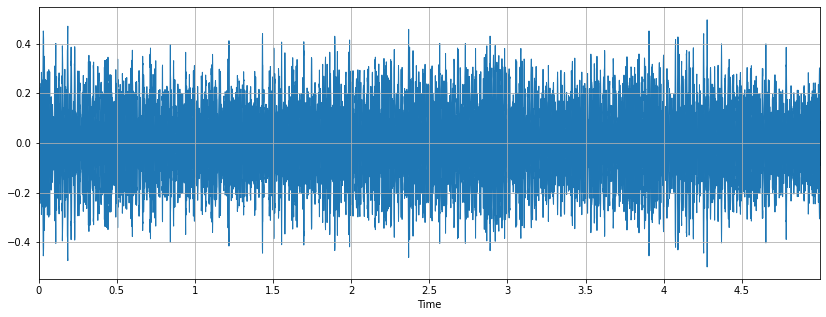

In [50]:
plt.figure(figsize=(14, 5))
librosa.display.waveplot(sub_data, sr=samplerate)
plt.grid()
plt.show()

Listen to the bird:

In [51]:
display.Audio(sub_data, rate=samplerate)

# Parameter
Based on the EDA we define some parameters:

In [60]:
data_lenght = 160000
audio_lenght = 5
num_labels = len(labels)
num_labels

49

For the Data Generator we want to define in the next step we need additional parameters:

In [61]:
batch_size = 16

# Train, Val And Test Data

In [62]:
samp_subm

,row_id,birds
0,3575_COL_5,nocall
1,3575_COL_10,nocall
2,3575_COL_15,nocall


In [63]:
list_IDs_train, list_IDs_val = train_test_split(list(train_labels.index), test_size=0.33, random_state=2021)
list_IDs_test = list(samp_subm.index)

# Audio Data Generator
We use a Data Generator to load the data on demand.

In [32]:
class DataGenerator(Sequence):
    def __init__(self, path, list_IDs, data, batch_size):
        self.path = path
        self.list_IDs = list_IDs
        self.data = data
        self.batch_size = batch_size
        self.indexes = np.arange(len(self.list_IDs))
        
    def __len__(self):
        len_ = int(len(self.list_IDs)/self.batch_size)
        if len_*self.batch_size < len(self.list_IDs):
            len_ += 1
        return len_
    
    def __getitem__(self, index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        list_IDs_temp = [self.list_IDs[k] for k in indexes]
        X, y = self.__data_generation(list_IDs_temp)
        X = X.reshape((self.batch_size, 100, 1600//2))
        return X, y
    
    def __data_generation(self, list_IDs_temp):
        X = np.zeros((self.batch_size, data_lenght//2))
        y = np.zeros((self.batch_size, num_labels))
        for i, ID in enumerate(list_IDs_temp):
            prefix = str(self.data.loc[ID, 'audio_id'])+'_'+self.data.loc[ID, 'site']
            file_list = [s for s in os.listdir(self.path) if prefix in s]
            if len(file_list) == 0:
                # Dummy for missing test audio files
                audio_file_fft = np.zeros((data_lenght//2))
            else:
                file = file_list[0]#[s for s in os.listdir(self.path) if prefix in s][0]
                audio_file, audio_sr = read_ogg_file(self.path, file)
                audio_file = audio_file[int((self.data.loc[ID, 'seconds']-5)/audio_lenght)*data_lenght:int(self.data.loc[ID, 'seconds']/audio_lenght)*data_lenght]
                audio_file_fft = np.abs(np.fft.fft(audio_file)[: len(audio_file)//2])
                # scale data
                audio_file_fft = (audio_file_fft-audio_file_fft.mean())/audio_file_fft.std()
            X[i, ] = audio_file_fft
            y[i, ] = self.data.loc[ID, self.data.columns[5:]].values
        return X, y

Test the Data Generator

In [33]:
train_generator = DataGenerator(path+'train_soundscapes/', list_IDs_train, train_labels, batch_size)
val_generator = DataGenerator(path+'train_soundscapes/', list_IDs_val, train_labels, batch_size)
test_generator = DataGenerator(path+'test_soundscapes/', list_IDs_test, test_data, batch_size)

In [64]:
train_labels.columns[5:]

Index(['rebwoo', 'gockin', 'brnjay', 'eastow', 'grycat', 'amecro', 'orcpar',
       'reevir1', 'cangoo', 'obnthr1', 'amerob', 'sthwoo1', 'norwat', 'crfpar',
       'rewbla', 'norfli', 'swaspa', 'chswar', 'blujay', 'orfpar', 'runwre1',
       'grhcha1', 'bucmot2', 'rubwre1', 'balori', 'hofwoo1', 'grekis',
       'clcrob', 'yehcar1', 'dowwoo', 'yebsap', 'melbla1', 'amegfi', 'comyel',
       'eawpew', 'woothr', 'whcpar', 'nocall', 'comgra', 'bkcchi', 'rtlhum',
       'ovenbi1', 'bobfly1', 'sonspa', 'norcar', 'plawre1', 'haiwoo',
       'belkin1', 'rucwar'],
      dtype='object')

In [65]:
train_labels.columns[:5]

Index(['row_id', 'site', 'audio_id', 'seconds', 'birds'], dtype='object')

In [66]:
"nocall" in train_labels.columns[5:]

True

# Define Model

In [34]:
epochs = 2
lernrate = 2e-3

In [35]:
model = Sequential()
model.add(Conv1D(64, input_shape=(100, 1600//2,), kernel_size=5, strides=4, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool1D(pool_size=(4)))
model.add(Conv1D(64, kernel_size=3, activation='relu'))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(num_labels, activation='sigmoid'))

In [36]:
model.compile(optimizer = Adam(lr=lernrate),
              loss='binary_crossentropy',
              metrics=['binary_accuracy'])

In [37]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 24, 64)            256064    
_________________________________________________________________
batch_normalization (BatchNo (None, 24, 64)            256       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 6, 64)             0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 4, 64)             12352     
_________________________________________________________________
batch_normalization_1 (Batch (None, 4, 64)             256       
_________________________________________________________________
flatten (Flatten)            (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 256)               6

In [38]:
history = model.fit_generator(generator=train_generator, validation_data=val_generator, epochs = epochs, workers=4)

Epoch 1/2
101/101 [==============================] - 1444s 14s/step - loss: 0.1571 - binary_accuracy: 0.9372 - val_loss: 0.0515 - val_binary_accuracy: 0.9838
Epoch 2/2
101/101 [==============================] - 1443s 14s/step - loss: 0.0428 - binary_accuracy: 0.9869 - val_loss: 0.0449 - val_binary_accuracy: 0.9864


# Analyse Training

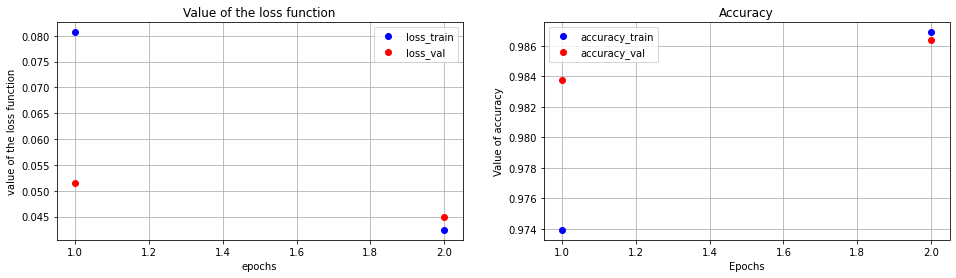

In [39]:
fig, axs = plt.subplots(1, 2, figsize=(16, 4))
fig.subplots_adjust(hspace = .2, wspace=.2)
axs = axs.ravel()
loss = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(1, len(loss)+1)
axs[0].plot(epochs, loss, 'bo', label='loss_train')
axs[0].plot(epochs, loss_val, 'ro', label='loss_val')
axs[0].set_title('Value of the loss function')
axs[0].set_xlabel('epochs')
axs[0].set_ylabel('value of the loss function')
axs[0].legend()
axs[0].grid()
acc = history.history['binary_accuracy']
acc_val = history.history['val_binary_accuracy']
axs[1].plot(epochs, acc, 'bo', label='accuracy_train')
axs[1].plot(epochs, acc_val, 'ro', label='accuracy_val')
axs[1].set_title('Accuracy')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Value of accuracy')
axs[1].legend()
axs[1].grid()
plt.show()

# Predict Test Data

In [40]:
y_pred = model.predict_generator(test_generator, verbose=1)

1/1 [==============================] - 0s 156ms/step


Set all values grather than 0.5 to 1:

In [41]:
y_test = np.where(y_pred > 0.5, 1, 0)

Generate target label string:

In [42]:
for row in samp_subm.index:
    string = ''
    for col in range(len(y_test[row])):
        if y_test[row][col] == 1:
            if string == '':
                string += labels[col]
            else:
                string += ' ' + labels[col]
    if string == '':
        string = 'nocall'
    samp_subm.loc[row, 'birds'] = string

# Export

In [43]:
output = samp_subm
output.to_csv('submission.csv', index=False)

In [44]:
output

,row_id,birds
0,3575_COL_5,nocall
1,3575_COL_10,nocall
2,3575_COL_15,nocall


## Northern / Southern Semisphere?

In [73]:
train_meta[["primary_label", "date", "latitude", "longitude"]].head(10)

,primary_label,date,latitude,longitude
0,acafly,2012-08-12,35.3860,-84.1250
1,acafly,2000-12-26,9.1334,-79.6501
2,acafly,2012-01-10,5.7813,-75.7452
3,acafly,2009-06-19,4.6717,-75.6283
4,acafly,2009-06-19,4.6717,-75.6283
5,acafly,2007-11-05,4.6717,-75.6283
6,acafly,2007-11-12,4.6717,-75.6283
7,acafly,2007-11-12,4.6717,-75.6283
8,acafly,2007-12-02,4.6717,-75.6283
9,acafly,2008-02-07,4.6717,-75.6283


In [82]:
np.random.choice(len(train_meta), size=10, replace=False)

array([10707,  3347, 39408, 49087, 27787,  2340, 49128, 11760, 17532,
       25703])

In [85]:
train_meta.loc[np.random.choice(len(train_meta), size=10, replace=False),
               ["primary_label", "date", "latitude", "longitude"]]

,primary_label,date,latitude,longitude
11293,bugtan,2018-08-26,-4.2889,-70.2948
52790,swathr,2013-07-20,44.2570,-68.3890
44405,rotbec,2019-03-02,13.7870,-87.2759
35386,mouwar,1992-06-01,40.3911,-74.0341
32565,lobdow,2017-07-08,70.9409,147.9749
5773,bewwre,2015-01-13,34.2876,-114.0652
26915,grnher,2014-05-26,25.3820,-80.6163
40982,prowar,2016-04-01,34.6618,-89.4701
36761,normoc,2017-12-14,26.1253,-97.9532
11512,bulori,2009-05-01,31.9060,-109.1543


In [68]:
train_meta["longitude"].max(), train_meta["longitude"].min()

(179.3607, -165.7812)

In [69]:
train_meta["latitude"].max(), train_meta["latitude"].min()

(78.9281, -53.162)